In [9]:
from IPython.core.display import HTML
HTML("""
<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>""")


In [4]:
import sqlite3
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import json
import gzip
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [9]:
def create_openalex():
    """
    Create csv file for pre-processed OpenAlex dataset.
    Check if csv file is already existing in current directory.
    If not, get file from shared folder from Jojie. To optimize
    program run, read JSON files in chunks then convert chunks to
    dataframe in a list. Merge dataframes in list to a single
    dataframe then convert to csv file.
    """
    try:
        openalex = pd.read_csv('open_alex.csv')
    except FileNotFoundError:
        filepath = ('/mnt/data/public/openalex/data/'
        'works/updated_date=2022-09-16/part_000.gz')

        # Change dtype of works data to save memory.
        dtypes_dict = {
                        'id':'str',
                        'doi': 'str',
                        'display_name':'str',
                        'title': 'str',
                        'publication_year': 'int64',
                        'publication_date': 'str',
                        'ids': 'str',
                        'host_venue': 'str',
                        'type': 'str',
                        'open_access': 'str',
                        'authorships': 'str',
                        'cited_by_count': 'int64',
                        'biblio': 'str',
                        'is_retracted': 'bool',
                        'is_paratext': 'float64',
                        'concepts': 'str',
                        'mesh': 'str',
                        'alternate_host_venues': 'str',
                        'referenced_works': 'str',
                        'related_works': 'str',
                        'abstract_inverted_index': 'str',
                        'counts_by_year': 'int64',
                        'cited_by_api_url': 'str',
                        'updated_date': 'str',
                        'created_date': 'str'
        }

        # Divide data in chunks to save memory
        df2 = pd.read_json(filepath,
                           lines=True,
                           compression='gzip',
                           dtype=dtypes_dict,
                           chunksize=1_000)

        # Merge chunks into a single dataframe
        df2_list = []
        for chunk in df2:
            df = pd.DataFrame(chunk)
            df2_list.append(df)

        df2_merged = pd.DataFrame([],
                                  columns=['id',
                                           'doi',
                                           'title',
                                           'type',
                                           'publication_date',
                                           'authorships',
                                           'cited_by_count',
                                           'concepts'])
        for data in df2_list:
            df_data = data[['id',
                            'doi',
                            'title',
                            'type',
                            'publication_date',
                            'authorships',
                            'cited_by_count',
                            'concepts']]
            df2_merged = pd.concat([df2_merged, df_data])

        # Extract location of research and country code from
        # authorships column
        df2_cleaned = df2_merged.copy()
        df2_cleaned['location'] = (df2_cleaned['authorships']
                                   .apply(lambda x: re
                                          .findall(r'\'display_name'
                                                   r'\'\:\s\'(.*?)\'',
                                                   x)))

        df2_cleaned['country_code'] = (df2_cleaned['authorships']
                                       .apply(lambda x:
                                              re.findall(r'\'country_code'
                                                         r'\'\:\s\'(.*?)\'',
                                                         x)))

        # Extract author of research and institution from
        # location column
        df2_cleaned['author'] = df2_cleaned['location'].str[0]
        df2_cleaned['institution'] = df2_cleaned['location'].str[1]

        # Drop authorships and location columns
        df_openalex_works = df2_cleaned.drop(['authorships', 'location'],
                                             axis=1)

        # Save the final OpenAlex dataframe to a csv file
        df_openalex_works.to_csv('open_alex.csv', index=False)

def create_cord19():
    """
    Create csv file for CORD19 dataset. Read individual JSON files
    and load them into a single dataframe. Extract author names,
    and normalize the data to extract important columns under
    affiliations.
    """
    try:
        cord19 = pd.read_csv('cord19.csv')
    except FileNotFoundError:
        path_cord19 = ('/mnt/data/public/covid19-lake'
                      '/alleninstitute/CORD19/raw/')
        folders = os.listdir(path_cord19)

        df = pd.DataFrame()
        for folder in folders[:2]+folders[3:5]:
            dir_ = os.path.join(path_cord19, folder)
            for json_file in os.listdir(dir_):
                with open(os.path.join(dir_, json_file)) as file:
                    data = json.load(file)
                authors = pd.json_normalize(pd.Series(data['metadata']
                                                      ['authors']))
                title = pd.Series([data['metadata']['title']] * len(authors))
                authors.insert(loc=0, column='sha', value=data['paper_id'])
                authors.insert(loc=0, column='title', value=title)
                df = pd.concat([df, authors])
        df = df.reset_index(drop=True)
        df.to_csv('cord19.csv', index=False)

def create_worldcases():
    """
    Create csv file for Worldcases dataset. Filter raw data of
    unnecessary columns.
    """
    filepath = ('/mnt/data/public/covid19-lake/rearc-covid-'
               '19-world-cases-deaths-testing/json/part-00000'
               '-ec012cca-b605-4eb8-a9c2-3e35982f9f71-c000.json')
    df_dead = pd.read_json(filepath, lines=True)
    df_dead = df_dead[["iso_code", "date", "location", "total_cases", 
                       "new_cases", "total_deaths", "total_tests",
                      "total_deaths_per_million"]]
    df_dead = df_dead.fillna(0)
    df_dead["date"] = pd.to_datetime(df_dead["date"])
    df_dead.sort_values(by= "date",
                        ascending=False,
                        inplace=True)
    df_dead.to_csv('worldcases.csv', index=False)

def create_database():
    """
    Create SQLite database using OpenAlex, CORD19, CORD19 metadata,
    and Worldcases dataframes as tables.
    """
    conn = sqlite3.connect("dmw_lab1.db")
    c = conn.cursor()
    c.execute("""CREATE TABLE IF NOT EXISTS open_alex_works (id, 
              doi, title, type, publication_date, cited_by_count,
              concepts, country_code, author, institution)""")
    conn.commit()

    df_openalex = pd.read_csv('open_alex.csv')
    df_openalex.to_sql('open_alex_works',
                       conn,
                       if_exists='replace',
                       index=False)

    df_cord19 = pd.read_csv('/mnt/processed/private/msds2023/lt6/cord19.csv')
    df_cord19.to_sql('cord19',
                     conn,
                     if_exists='replace',
                     index=False)

    df_worldcases = pd.read_csv('worldcases.csv')
    df_worldcases.to_sql('worldcases',
                          conn,
                          if_exists='replace',
                          index=False)

    df_metadata = pd.read_csv('/mnt/data/public/covid19-lake/alleninstitute/'
                              'CORD19/raw/metadata/metadata.csv')
    df_metadata.to_sql('cord19_metadata',
                       conn,
                       if_exists='replace',
                       index=False)
    return conn


![Title](title.png)

## Executive Summary

If doctors and scientists reacted slower when the pandemic hit in the year 2020, how long do you think we’d have some semblance of pre-pandemic normalcy? How worse off would nations and economies have it? How would it have impacted the mental health of every adult and child? And how many more people would’ve died if there were no research in place to combat the pandemic?

The COVID-19 pandemic was unprecedented, it disrupted all facets of life, and we continue to feel the effects of it in our everyday lives. If not for the swift and timely research conducted by scientists and experts in multiple fields, we would still be back in the year 2020, where even the most basic things like going out to buy groceries were a scary prospect. As such, the team wanted to identify who were the thought leaders, the experts, the valiant scientists, and institutions who contributed most to the fight against COVID-19 and thus paved the way to lowering the mortality rates of countries across the globe. 

The team used datasets from COVID-19 Data Lake containing the COVID-19 Open Research Dataset (CORD-19) and COVID-19 World Cases and Deaths. In addition, the team also used the OpenAlex, a free and open catalog of the world’s scholarly papers corroborate the insights obtained from the COVID-19 Data Lake.

Results show that the top authors contributed more than 60 publications based on the data. The top institutions came mostly from China and the United States of America whether by number of publications or number citations.

# Introduction

Looking back in the course of history, many pandemics have occurred such as the HIV/AIDS Pandemic and the Influenza Pandemic. In order to end these pandemics, the research done by various doctors and scientists were able to create remedies and antidotes. Important research that was able to save millions of lives. With the COVID-19 Pandemic, there is currently no antidote yet on fully treating the disease instantly. 
  
In retrospect, the first ones who were able to find ways on how to properly deal with the COVID-19 virus were the ones able to prevent countless lives being lost with their research when not everyone was aware of COVID-19 yet. Taking this into consideration, the team wants to figure out who emerged as thought leaders during this pandemic. Their research has saved more lives, as they were able to react and adjust quicker to the pandemic. 
 
Given how the current pandemic changed everyone’s way of life entirely, the team would like to investigate and to evaluate who had the most research pertaining to COVID-19. They were able to soften the blow of the pandemic with their research. The team believes that these people have the best chance of finding a solution for COVID-19. 

## Problem Statement

Despite all attempts to eradicate COVID-19, the disease still plagues many countries. The team conducted a study to figure out who contributed the most to COVID-19's research progress and which research topics are essential to understanding the virus.

## Objectives

- To identify who emerged as thought leaders on COVID-19 research.
- To identify the most prominent areas of COVID-19 research.
- To identify whether a relationship exists between the number of COVID-19 related research and the number of cases and death per country.

## Data Description

The team used the COVID-19 Data Lake as its main dataset and OpenAlex as a secondary dataset. The team considered a subset of each dataset to answer the objectives of the study. In particular, the COVID-19 Open Research Dataset (CORD-19) contains over 45,000 research articles (over 33,000 with full text) about COVID-19, SARS-CoV-2, and other coronaviruses. OpenAlex contains a works dataset that collates scholarly documents like journal articles, books, and theses. The team also used the Rearc World Cases dataset which is also found in the COVID-19 Data Lake. The Rearc World Cases dataset contains information such as total deaths and total cases on a given date.

## Scope and Limitations

Like other studies, this study also has its limitations. The team acknowledges that the data from the CORD-19 dataset does not necessarily exist in the OpenAlex dataset and vice versa. There may also be COVID-19 related publications that were not included in the dataset.  

The team limits this research to the raw data in the COVID-19 Data Lake, specifically the CORD-19 dataset. Another limitation was that upon inspection, the OpenAlex dataset was not complete. It was still for completion. The database was also so large that it takes time to be able to load it. 

Moreover, the qualitative impact of each publication is difficult to measure without the use of natural language processing. Therefore, the study focuses on measuring contributions and impact based on quantity of publications and their corresponding number of citations. 

## Methodology

The high-level methodology is composed of five steps named below. The steps taken for each are discussed below.

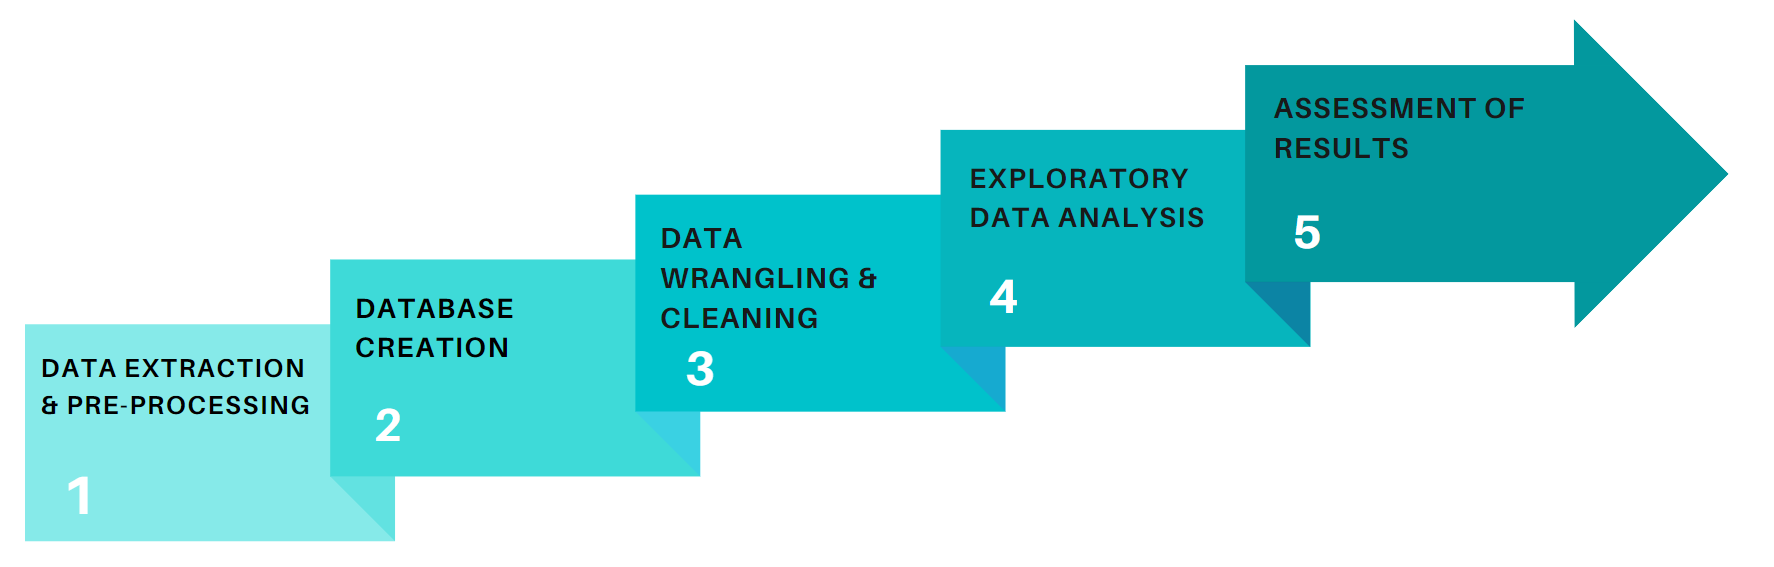

A conceptual framework describing the first four steps of the methodology is also provided in the illustration below.

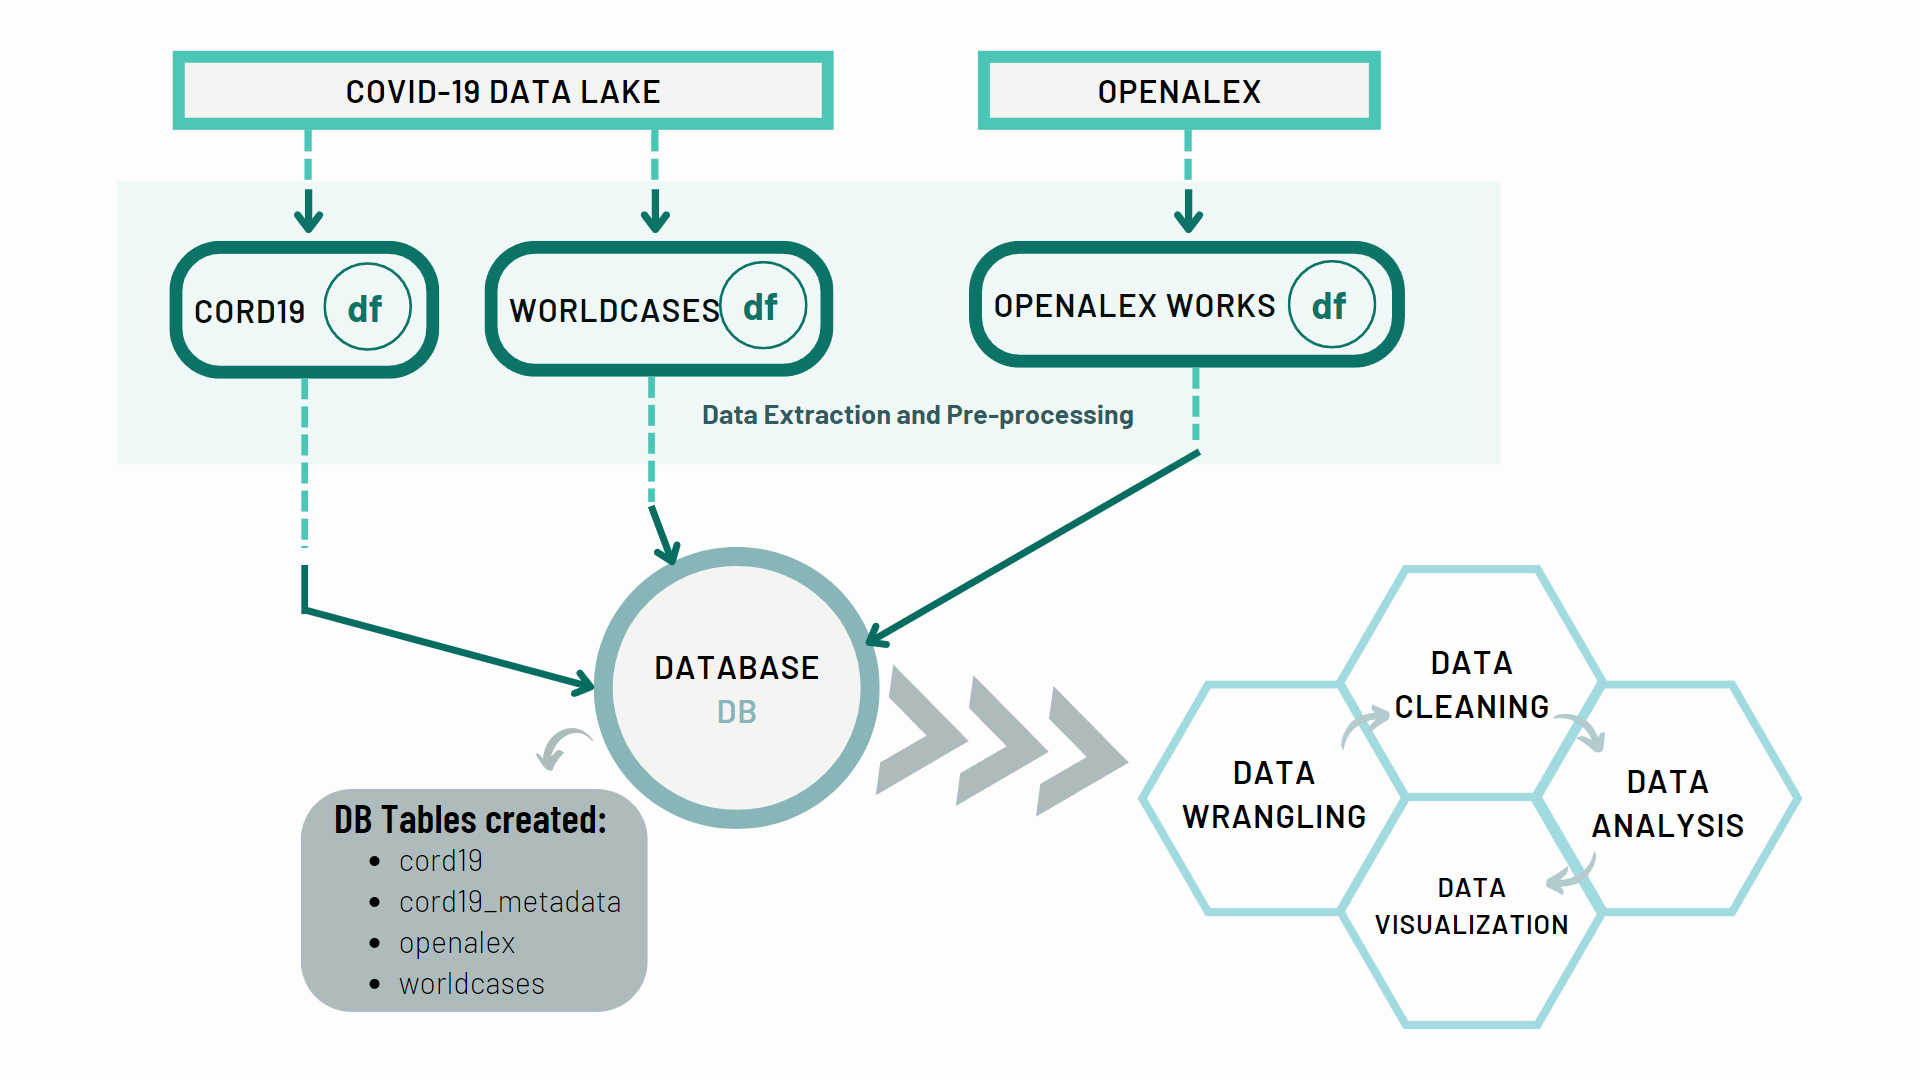

# Data Extraction and Pre-processing

The first step taken in the methodology is the extraction of the datasets from COVID-19 Data Lake and OpenAlex. All datasets are JSON files and require pre-processing before loading to the database. Note that pre-processing of the raw data are done in here before loading to the database to optimize program run time. Reading the JSON files from the sources normally takes too long and causes frequent dead kernel. The following are the steps taken to extract and pre-process each dataset optimally.

For the CORD-19 Dataset:

The CORD19 raw files are individual JSON file of a publication with text in AWS. Each json file contains a list of authors. Each author has an affiliation (affiliation has further properties like country, laboratory, institution, etc). During pre-processing, a dataframe that matches an author with their affiliation normalized (using `json_normalize`) as columns was created. Also, during pre-processing, all columns of the created dataframe are retained. CORD19 metadata file is also used as an additional dataset for CORD19. This file includes all other COVID19 related researches with and without their respective full-text. Full features of the CORD19 dataset are however included in this dataset. All features are included in the table of the database.

For the Worldcases Dataset:

The World Cases dataset is a single JSON file. During pre-processing, the file is read and converted to a dataframe. None values are replaced with 0. Since the focus of this study is on COVID-19 cases and deaths, unnecessary and redundant columns were dropped. Below is a summary of the data features.

| Features of Raw Data | Converted Data Type | Status |
|:--------|:----------|:--------|
|iso_code | object | Retained |
|location | object | Retained |
|date | datetime64[ns] | Retained |
|total_cases | float64 | Retained dd|
|new_cases | float64 | Retained |
|total_cases_per_million | float64 | Dropped |
|new_cases_per_million | float64 | Dropped |
|tests_units | object | Dropped |
|total_deaths | float64 | Dropped |
|new_deaths | float64 | Dropped |
|total_deaths_per_million | float64 | Retained |
|new_deaths_per_million | float64 | Dropped |
|total_tests | float64 | Retained |
|new_tests | float64 | Dropped |
|total_tests_per_thousand | float64 | Dropped |
|new_tests_per_thousand | float64 | Dropped |

For the OpenAlex dataset:

The JSON file under works dataset of the OpenAlex website which was last updated on September 16, 2022 was extracted. The following are the steps taken to optimize loading of the files to a dataframe. First, the files need to be read in chunks and each chunk is loaded to a dataframe then stored to a list. The data types were converted from object type to either `string` or `int64`. The list of dataframes are then merged into a single dataframe. Upon inspection, the team noticed that there are useful information that can be extracted from a few columns. Only the useful information are then extracted and a few unncessary columns are dropped. Below is a summary of the features extracted and dropped for this dataset.

| Features of Raw Data | Converted Data Type | Status |
|:--------|:----------|:--------|
|id| str |Retained|
|doi| str |Retained|
|display_name| str |Dropped|
|title| str |Retained|
|publication_year| str |Dropped|
|publication_date| str |Retained|
|ids| str | Dropped|
|host_venue| str | Dropped|
|type| str | Retained|
|open_access| str |Dropped|
|authorships| str |Extracted then dropped|
|cited_by_count|int64|Retained|
|biblio|str|Dropped|
|is_retracted|bool|Dropped|
|is_paratext|float64|Dropped|
|concepts|string|Retained|
|mesh|str|Dropped|
|alternate_host_venues|str|Dropped|
|referenced_works|str|Dropped|
|related_works|str|Dropped|
|abstract_inverted_index|str|Dropped|
|counts_by_year|int64|Dropped|
|updated_date|str|Dropped|
|created_date|str|Dropped|
|country_code|str|Extracted from Authorships|
|author|str|Extracted from Authorships|
|institutions|str|Extracted from Authorships|

# Database Creation

After the datasets are pre-processed and stored in their respective `.csv` files, a SQLite database was created and the dataframes were loaded as tables into this database. A total of four tables were loaded to the database: $2$ from CORD-19, $1$ from Worldcases, and $1$ from OpenAlex.

In [10]:
# Create dataframes to be stored as table to the database
# Create dataframe for Openalex dataset
create_openalex()
# Create dataframe for Cord19 dataset
create_cord19()
# Create dataframe for World Cases dataset
create_worldcases()

# Create the database
conn = create_database()


In [11]:
conn.execute('SELECT name FROM sqlite_master WHERE type="table"').fetchall()

[('cordmeta',),
 ('open_alex_works',),
 ('cord19',),
 ('worldcases',),
 ('cord19_metadata',)]

# Data Wrangling and Cleaning

Before performing exploratory data analysis, the team first processed the datasets as shown below.


## Top 10 Authors with the Most Contributions

The first goal is to determine the top contributors to COVID-19 related researches based on research articles from the COVID-19 Data Lake provided by AWS. The CORD19 dataset is used in this case. The number of research works contributed by various authors are counted and ranked and top 10 authors are generated. In addition to this, the institutions and countried from where the authors came from are also ranked and the top of these are generated.

In [12]:
# Get the top 10 contributing authors in the dataset
statement = """
    SELECT 
        (first || ' ' || last) AS name,
        COUNT(title) as count
    FROM cord19
    GROUP BY
        name
    ORDER BY
        count DESC
    LIMIT 1, 10
"""
cord_authors = pd.read_sql(statement, conn)

# Get the first appearance of institution of each top author.
statement = """
    SELECT 
        (first || ' ' || last) AS name,
        [affiliation.institution] AS institution
    FROM cord19
"""
auth_inst = pd.read_sql(statement, conn)
auth_inst = (auth_inst[~auth_inst['institution'].isna()]
             .drop_duplicates('name'))

# Get the country of each top author
statement = """
    SELECT 
        (first || ' ' || last) AS name,
        [affiliation.location.country] AS country
    FROM cord19
"""
auth_country = pd.read_sql(statement, conn)
auth_country = (auth_country[~auth_country['country'].isna()]
                .drop_duplicates('name'))

cord_authors = cord_authors.merge(auth_inst, how='left', on='name')
cord_authors = cord_authors.merge(auth_country, how='left', on='name')
cord_authors[['name', 'institution', 'country']].rename(
    columns={
        'name': 'Name',
        'institution': 'Institution',
        'country': 'Country'
    }
)

,Name,Institution,Country
0,Ralph Baric,University of North Carolina at Chapel Hill,USA
1,Kwok-Yung Yuen,The University of Hong Kong,China
2,Shibo Jiang,Fudan University,China
3,Ziad Memish,Ministry of Health,Saudi Arabia
4,Christian Drosten,Princeton University,USA
5,Stanley Perlman,University of Iowa,USA
6,George Gao,University of Science and Technology of China,China
7,Luis Enjuanes,Leiden University Medical Center,The Netherlands
8,Lin-Fa Wang,Duke-National University of Singapore Medical ...,Singapore
9,Lanying Du,New York Blood Center,USA


## Top 10 Institutions with the Most Contributions

In [13]:
statement = """
    SELECT
        [affiliation.institution] AS institution,
        COUNT([affiliation.institution]) AS count
    FROM cord19
    GROUP BY
        [affiliation.institution]
    ORDER BY
        count DESC
    LIMIT 10
"""
top_inst = pd.read_sql(statement, conn)
top_inst

,institution,count
0,Chinese Academy of Sciences,1890
1,National Institutes of Health,1297
2,University of California,1255
3,The University of Hong Kong,1011
4,Chinese Academy of Agricultural Sciences,816
5,Fudan University,649
6,Wuhan University,554
7,University of Washington,541
8,The Chinese University of Hong Kong,533
9,Utrecht University,528


## Top 10 Countries with the Most Publications

In [14]:
df_cord19 = pd.read_sql("""
            SELECT
                distinct title AS TITLE, [affiliation.location.country], sha
            FROM cord19
            WHERE LOWER(title) LIKE '%covid%' 
            """, conn)

df_metadatasql = pd.read_sql("""
            SELECT
                title AS metatitle, abstract, publish_time, authors, sha
            FROM cord19_metadata
            WHERE title LIKE '%COVID%' 
            """, conn)

df_cntryt = pd.merge(df_cord19, df_metadatasql, how="left")
sql_cntryt = df_cntryt.to_sql('cordmeta',
                 conn,
                 if_exists='replace',
                 index=False)

df_china = pd.read_sql("""
            SELECT
                distinct title AS TITLE,
                [affiliation.location.country] AS China,
                sha,
                publish_time
            FROM cordmeta
            WHERE LOWER(title) LIKE '%covid%'
            AND [affiliation.location.country] LIKE '%China%'
            """, conn)
df_usa = pd.read_sql("""
            SELECT
                distinct title AS TITLE,
                [affiliation.location.country] AS [United States],
                sha,
                publish_time
            FROM cordmeta
            WHERE LOWER(title) LIKE '%covid%'
            AND ([affiliation.location.country] LIKE '%USA%'
            OR [affiliation.location.country] LIKE '%United States%')
            """, conn)
df_italy = pd.read_sql("""
            SELECT
                distinct title AS TITLE,
                [affiliation.location.country] AS Italy,
                sha,
                publish_time
            FROM cordmeta
            WHERE LOWER(title) LIKE '%covid%'
            AND [affiliation.location.country] LIKE '%Italy%'
            """, conn)
df_jpn = pd.read_sql("""
            SELECT
                distinct title AS TITLE,
                [affiliation.location.country] AS Japan,
                sha,
                publish_time
            FROM cordmeta
            WHERE LOWER(title) LIKE '%covid%'
            AND [affiliation.location.country] LIKE '%japan%'
            """, conn)
df_uk = pd.read_sql("""
            SELECT
                distinct title AS TITLE,
                [affiliation.location.country] AS [United Kingdom],
                sha,
                publish_time
            FROM cordmeta
            WHERE LOWER(title) LIKE '%covid%'
            AND ([affiliation.location.country] LIKE '%UK%'
            OR [affiliation.location.country] LIKE '%United kingdom%')
            """, conn)
df_cnd = pd.read_sql("""
            SELECT
                distinct title AS TITLE,
                [affiliation.location.country] AS Canada,
                sha,
                publish_time
            FROM cordmeta
            WHERE LOWER(title) LIKE '%covid%'
            AND [affiliation.location.country] LIKE '%canada%'
            """, conn)
df_france = pd.read_sql("""
            SELECT
                distinct title AS TITLE,
                [affiliation.location.country] AS France,
                sha,
                publish_time
            FROM cordmeta
            WHERE LOWER(title) LIKE '%covid%'
            AND [affiliation.location.country] LIKE '%france%'
            """, conn)
df_iran = pd.read_sql("""
            SELECT
                distinct title AS TITLE,
                [affiliation.location.country] AS Iran,
                sha,
                publish_time
            FROM cordmeta
            WHERE LOWER(title) LIKE '%covid%'
            AND [affiliation.location.country] LIKE '%iran%'
            """, conn)
df_australia = pd.read_sql("""
            SELECT
                distinct title AS TITLE,
                [affiliation.location.country] AS Australia,
                sha,
                publish_time
            FROM cordmeta
            WHERE LOWER(title) LIKE '%covid%'
            AND [affiliation.location.country] LIKE '%australia%'
            """, conn)
df_taiwan = pd.read_sql("""
            SELECT
                distinct title AS TITLE,
                [affiliation.location.country] AS Taiwan,
                sha,
                publish_time
            FROM cordmeta
            WHERE LOWER(title) LIKE '%covid%'
            AND [affiliation.location.country] LIKE '%taiwan%'
            """, conn)

dic_leadcount = {
    "China" : df_china["sha"].nunique(),
    "United States of America" : df_usa["sha"].nunique(),
    "Italy" : df_italy["sha"].nunique(),
    "Japan" : df_jpn["sha"].nunique(),
    "Canada" : df_cnd["sha"].nunique(),
    "United Kingdom" : df_uk["sha"].nunique(),
    "France" : df_france["sha"].nunique(),
    "Iran" : df_iran["sha"].nunique(),
    "Australia" : df_australia["sha"].nunique(),
    "Taiwan" : df_taiwan["sha"].nunique()
}

df_countryleaders = (pd.DataFrame(
        dic_leadcount.items(), columns=['Country', 'Research Count']
    ).sort_values(by="Research Count", ascending=False)
)
df_countryleaders


,Country,Research Count
0,China,182
1,United States of America,67
5,United Kingdom,21
2,Italy,19
3,Japan,15
9,Taiwan,13
4,Canada,12
6,France,12
7,Iran,10
8,Australia,8


## Merge CORD19 Dataset with OpenAlex Dataset

The CORD19 dataset do not provide the number of citations for each research article. In this case, the OpenAlex dataset is used to lookup for the COVID-19 related researches from CORD19 metadata and then match this research articles to those available in the OpenAlex dataset. Matching is done using the digital object identifier of the research articles which are provided in both datasets. A preview of the merged dataset is provided below.

In [15]:
open_alex = pd.read_sql("""
            SELECT
                doi, title, cited_by_count, concepts,
                country_code, author, institution
            FROM open_alex_works
            """, conn)

open_alex_list = open_alex['title'].dropna().str.lower().to_list()

metadata = pd.read_sql("""
            SELECT
                title, doi, abstract, publish_time, authors
            FROM cord19_metadata
            """, conn)

metadata2 = metadata.copy()
metadata2['doi'] = 'https://doi.org/' + metadata['doi'].astype(str)

open_alex_doi_list = open_alex['doi'].dropna().str.lower().to_list()
cord19_url_list = metadata2['doi'].dropna().str.lower()
cord19_openalex = metadata2.loc[metadata2['doi'].isin(open_alex_doi_list)]
cord19_openalex_merged = cord19_openalex.merge(open_alex,
                                               how='left',
                                               on='doi')
cord19_openalex_merged.head()

,title_x,doi,abstract,publish_time,authors,title_y,cited_by_count,concepts,country_code,author,institution
0,Insights into Cross-species Evolution of Novel...,https://doi.org/10.1101/2020.01.29.925867,ABSTRACTNovel Coronavirus (nCoV) outbreak in t...,2020-01-30,Arunachalam Ramaiah; Vaithilingaraja Arumugaswami,Insights into Cross-species Evolution of Novel...,29,"[{'id': 'https://openalex.org/C86803240', 'wik...",[],Arunachalam Ramaiah,Department of Ecology and Evolutionary Biology...
1,Isolation and Characterization of 2019-nCoV-li...,https://doi.org/10.1101/2020.02.17.951335,AbstractThe outbreak of 2019-nCoV in the centr...,2020-02-20,Kangpeng Xiao; Junqiong Zhai; Yaoyu Feng; Niu ...,Isolation and Characterization of 2019-nCoV-li...,90,"[{'id': 'https://openalex.org/C2779813137', 'w...","['CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'CN...",Kangpeng Xiao,South China Agricultural University
2,"Generalized anxiety disorder, depressive sympt...",https://doi.org/10.1101/2020.02.19.20025395,Background: China has been severely affected b...,2020-02-23,Yeen Huang; Ning Zhao,"Generalized anxiety disorder, depressive sympt...",67,"[{'id': 'https://openalex.org/C2776245837', 'w...","['CN', 'CN']",Yeen Huang,Shenzhen University
3,Viral fitness predicts the magnitude and direc...,https://doi.org/10.1101/206789,Determining the fitness of viral genotypes has...,2017-10-20,Héctor Cervera; Silvia Ambrós; Guillermo P. Be...,Viral fitness predicts the magnitude and direc...,0,"[{'id': 'https://openalex.org/C86803240', 'wik...",['UY'],Héctor Cervera,IBMCP-CSIC;
4,A new coronavirus associated with human respir...,https://doi.org/10.1038/s41586-020-2008-3,"Emerging infectious diseases, such as SARS and...",2020,"Wu, Fan; Zhao, Su; Yu, Bin; Chen, Yan-Mei; Wan...",A new coronavirus associated with human respir...,6622,"[{'id': 'https://openalex.org/C116675565', 'wi...","['CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'CN...",Fan Wu,Shanghai Public Health Clinical Center


In [16]:
len(cord19_openalex_merged)

323

A total of 323 COVID-19 related research papers from CORD19 matched and have available number of citations from OpenAlex. 

## Filter Top 10 Contributors Based on the Number of Research Paper Citations

Using the merged dataset, the number of citations of each research articles are counted and the top 10 titles, main authors, institutions, and countries are ranked.

In [17]:
cord19_openalex_merged2 = (cord19_openalex_merged.sort_values('cited_by_count',
                                   ascending=False).head(10)
                          [['cited_by_count',
                            'title_y',
                            'authors',
                            'institution',
                            'publish_time',
                            'country_code']]).rename(columns={'title_y':
                                                              'title'})

cord19_openalex_merged2.loc[17, 'authors'] = (cord19_openalex_merged2
                                              .loc[17, 'authors']
                                              .replace(',', ';'))
cord19_openalex_merged2.authors = (cord19_openalex_merged2.authors
                                   .str.split(';').apply(lambda x: x[0]))
cord19_openalex_merged2.country_code = (
    cord19_openalex_merged2.country_code.apply(
        lambda x: max(set(ast.literal_eval(x)), key=ast.literal_eval(x).count)
    )
)
cord19_openalex_merged2.loc[cord19_openalex_merged2['country_code'] == 'GB', 'country_code'] = 'UK'
cord19_openalex_merged2

,cited_by_count,title,authors,institution,publish_time,country_code
13,9072,"Early Transmission Dynamics in Wuhan, China, o...","Li, Qun",Chinese Center For Disease Control and Prevention,2020-01-29,CN
301,6821,The psychological impact of quarantine and how...,"Brooks, Samantha K",Rebecca K. Webster,2020-03-20,UK
4,6622,A new coronavirus associated with human respir...,"Wu, Fan",Shanghai Public Health Clinical Center,2020,CN
206,4656,Global trends in emerging infectious diseases,"Jones, Kate E.",Zoological Society of London,2008-02-01,US
314,2889,Nowcasting and forecasting the potential domes...,"Wu, Joseph T","Li Ka Shing Faculty of Medicine, University of...",2020-03-06,HK
298,2886,Severe acute respiratory syndrome coronavirus ...,"Lai, Chih-Cheng",Kaohsiung Veterans General Hospital,2020-03-31,TW
17,2258,Substantial undocumented infection facilitates...,Ruiyun Li1,Imperial College London,2020-03-16,US
306,2145,Clinical characteristics and intrauterine vert...,"Chen, Huijun",Zhongnan Hospital of Wuhan University,2020-03-13,CN
264,1677,"Epidemiology, Genetic Recombination, and Patho...","Su, Shuo",Nanjing Agricultural University,2016-06-30,CN
14,1626,Virtually Perfect? Telemedicine for Covid-19,"Hollander, Judd E.",Thomas Jefferson University,2020-03-11,US


# Exploratory Data Analysis

In [83]:
# Count the number of unique authors and institutions
statement = """
    SELECT
        COUNT(DISTINCT((first || ' ' || last))) as unique_authors
    FROM cord19
"""
cord_authors_total = pd.read_sql(statement, conn)

statement = """
    SELECT
        COUNT(DISTINCT("affiliation.institution")) as unique_institution
    FROM cord19
"""
cord_institution_total = pd.read_sql(statement, conn)

unique = pd.concat([cord_authors_total,
                    cord_institution_total], axis=1).T

The number of unique authors, institutions, and countries in the dataset are:

| Unique | Number |
|:-:|:-:|
| Authors | **117,818** |
| Institutions | **13,274** |

## Top 10 Contributing Authors

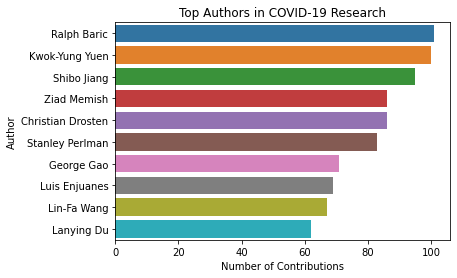

In [19]:
sns.barplot(
    x='count', y='name', data=cord_authors,
)
plt.title('Top Authors in COVID-19 Research')
plt.xlabel('Number of Contributions')
plt.ylabel('Author')
plt.show()

Dr. Ralph Baric, Distinguished Professor in the Department of Epidemiology, and Professor in the Department of Microbiology and Immunology at The University of North Carolina at Chapel Hill, leads the fight against COVID-19 based on the number of publications. He, along with Kwok-Yung Yuen and Shibo Jiang, are the top three individual contributors in COVID-19 research. As seen in the chart, they have contributed more than 90 publications each. This suggests that these authors have devoted more of their time to COVID-19 research. 

## Top 10 Contributing Institutions

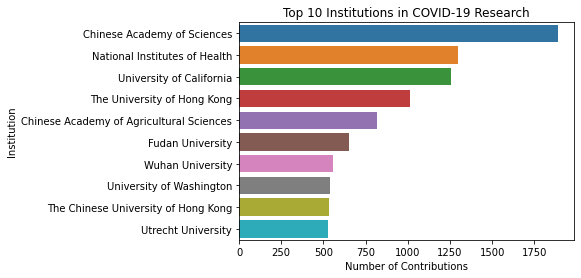

In [20]:
sns.barplot(
    x='count', y='institution', data=top_inst,
)
plt.title('Top 10 Institutions in COVID-19 Research')
plt.xlabel('Number of Contributions')
plt.ylabel('Institution')
plt.show()

The Chinese Academy of Sciences runs away with the top position in terms of COVID-19 research contributions with over 1,750. The National Institutes of Health and the University of California are a distant top 2 and 3, respectively. This suggests that the Chinese Academy of Sciences has allocated more resources in contributing to COVID-19 Research. Among the top 10 institutions, four are from China, three are from the United States of America, two are from Hong Kong, and Utretch University if from the Netherlands.

## Top 10 Publishing Countries

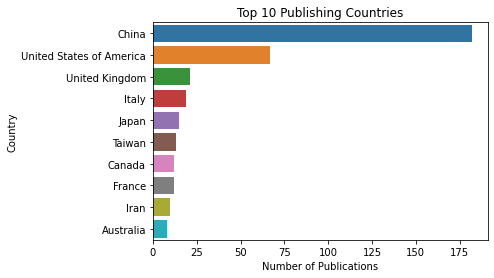

In [21]:
sns.barplot(data=df_countryleaders,
            x="Research Count", y="Country")

plt.title("Top 10 Publishing Countries")
plt.xlabel('Number of Publications')
plt.show()

China is the top publishing country with more than $175$ COVID-related publications done in 2020. The United States comes second among the top 10 with less than $100$ publications compared to China while those below generated with less than $25$ publications each. This could reflect China’s collective effort as a country in contributing to the COVID-19 investigation.

 ## Top Contributing Institutions that have the Top Contributing Authors

In [22]:
excel_inst = pd.Series(
    list(
        set(cord_authors['institution'])
        .intersection(set(top_inst['institution'])
        )
    )
)
excel_inst.rename('excellent_inst', inplace=True)

0    The University of Hong Kong
1               Fudan University
Name: excellent_inst, dtype: object

Among the top contributing authors, two are affiliated with some of the top contributing institutionso, namely:
- Kwok-Yung Yuen of the University of Hong Kong, and
- Shibo Jiang of Fudan University.

## Top 10 COVID-19 Researches Based on the Number of Citations

In [84]:
cord_oa_titles = cord19_openalex_merged2[['title', 'cited_by_count']].copy()
cord_oa_titles['short_title'] = cord_oa_titles.title.apply(lambda x: ' '.join(x.split()[:5]) + '...')

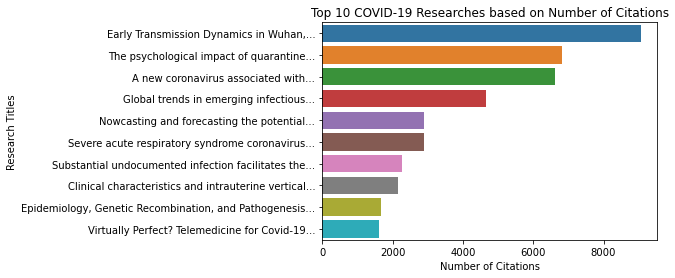

In [85]:
sns.barplot(
    x='cited_by_count', y='short_title', data=cord_oa_titles,
)
plt.title('Top 10 COVID-19 Researches based on Number of Citations')
plt.xlabel('Number of Citations')
plt.ylabel('Research Titles')
plt.show()

&ldquo;Early Transmission Dynamics in Wuhan, China of Novel Coronavirus-Infected Pneumonia&rdquo; is the top 1 COVID-19 research with over 8,000 citations. This implies that the said publication had a large impact in COVID-19 research, especially since COVID-19 was first discovered in Wuhan, China.  

## Top 10 Institutions Based on the Number of Citations

In [26]:
cord_oa_insti = cord19_openalex_merged2[['institution', 'cited_by_count']]

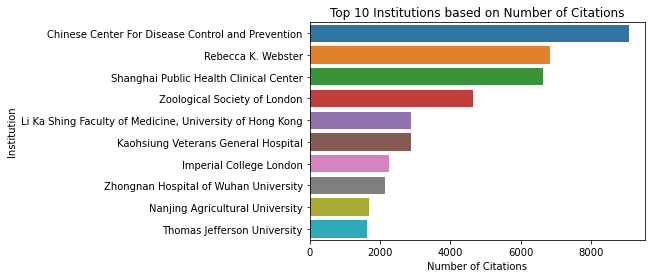

In [27]:
sns.barplot(
    x='cited_by_count', y='institution', data=cord_oa_insti,
)
plt.title('Top 10 Institutions based on Number of Citations')
plt.xlabel('Number of Citations')
plt.ylabel('Institution')
plt.show()

The Chinese Center For Disease Control and Prevention is the top 1 institution with over 8,000 citations. Rebecca K. Webster and Shanghai Public Health Clinical Center are next with more than 6,000 citations each. With 2 out of the top 3 institutions originating in China, this suggests that these Chinese institutes have more works that contribute to COVID-19 research. 

## Top 5 Countries Based on the Number of Citations

In [28]:
cord_oa_country = cord19_openalex_merged2[['country_code', 'cited_by_count']]
cord_oa_country = (cord_oa_country.groupby('country_code')
                   .sum().sort_values('cited_by_count',
                                      ascending=False)).reset_index()

country_dict = {
    'CN': 'China',
    'US': 'United States of America',
    'UK': 'United Kingdom',
    'HK': 'Hong Kong',
    'TW': 'Taiwan'
}
cord_oa_country.replace({'country_code': country_dict}, inplace=True)


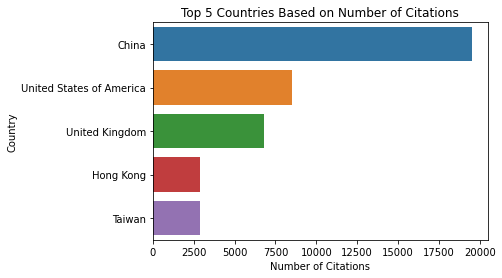

In [29]:
sns.barplot(
    x='cited_by_count', y='country_code', data=cord_oa_country,
)
plt.title('Top 5 Countries Based on Number of Citations')
plt.xlabel('Number of Citations')
plt.ylabel('Country')
plt.show()

China is the top country with almost 20,000 citations. The United States and United Kingdom are a distant 2 and 3 with less than 10,000 citations each. This suggests that China is more likely to be cited because the COVID-19 originated from China. 

## Concept Tags of COVID-19 Related Research based on the Number of Citations

In [30]:
com = cord19_openalex_merged
com['year'] = pd.DatetimeIndex(com['publish_time']).year
com = com.drop(['publish_time', 'doi'], axis=1)
com = com.sort_values('cited_by_count', ascending=False)

display_name = []
for k in range(len(com)):
    com1 = com.head(k)
    for i in com1.concepts:
        new = ast.literal_eval(i)
        for j in new:
            display_name.append(j['display_name'])


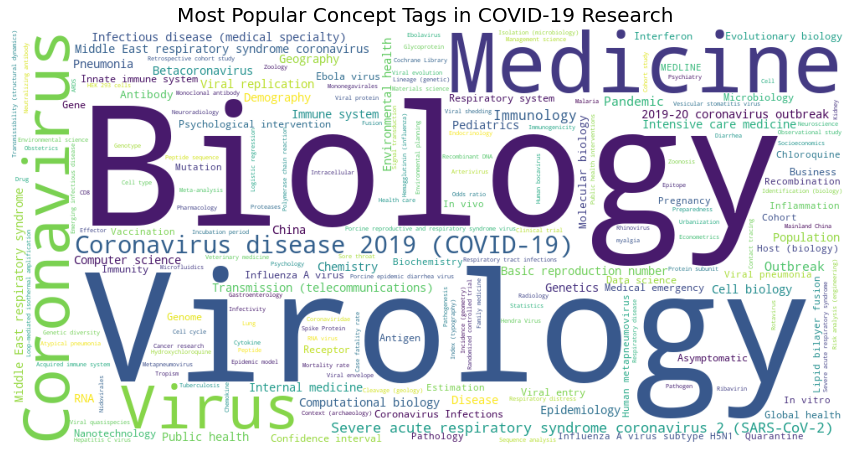

In [31]:
word_could_dict=Counter(display_name)
wordcloud = (WordCloud(width=1000,
                       height=500,
                       background_color='white')
             .generate_from_frequencies(word_could_dict))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title('Most Popular Concept Tags in COVID-19 Research',
          fontsize=20)
plt.axis("off")
plt.show()
plt.savefig('yourfile.png', bbox_inches='tight')
plt.close()


The most popular concept tags are Biology, Virology, Medicine, Coronavirus, and Virus. The team noticed that there were less concept tags on pandemic, infectious disease, and immunology. On the other hand, tags on vaccines and PPEs were not as common. These are some areas that may be further explored in research.

## Trend of Research Against Deaths for the Top Publishing Countries

In [56]:
dfs = [df_china, df_usa, df_italy, df_jpn, df_cnd, df_uk,
      df_france, df_iran, df_australia, df_taiwan]
countryname = []
def make_dates(df_list):
    
    for df in df_list:
        df["publish_time"] = pd.to_datetime(df["publish_time"])
        df['year'] = (pd.DatetimeIndex(df['publish_time']
                                      ).year.fillna(0)).astype(int)
        df['month'] = ((pd.DatetimeIndex(df['publish_time']
                                        ).month.fillna(0)).astype(int))
make_dates(dfs)



df_countries = pd.DataFrame({"month":np.arange(0,13)})
df_countries = (pd.merge(df_countries, df_china.groupby("month")["China"]
                         .count().fillna(0), how="left", on="month"))
df_countries = (pd.merge(df_countries,
                         df_usa.groupby("month")["United States"]
                         .count(), how="left", on="month"))
df_countries = (pd.merge(df_countries, df_italy.groupby("month")["Italy"]
                         .count(), how="left", on="month"))
df_countries = (pd.merge(df_countries, df_jpn.groupby("month")["Japan"]
                         .count(), how="left", on="month"))
df_countries = (pd.merge(df_countries, df_cnd.groupby("month")["Canada"]
                         .count(), how="left", on="month"))
df_countries = (pd.merge(df_countries,
                         df_uk.groupby("month")["United Kingdom"]
                         .count(), how="left", on="month"))
df_countries = (pd.merge(df_countries, df_france.groupby("month")["France"]
                         .count(), how="left", on="month"))
df_countries = (pd.merge(df_countries, df_iran.groupby("month")["Iran"]
                         .count(), how="left", on="month"))
df_countries = (pd.merge(df_countries,
                         df_australia.groupby("month")["Australia"]
                         .count(), how="left", on="month"))
df_countries = (pd.merge(df_countries, df_taiwan.groupby("month")["Taiwan"]
                         .count(), how="left", on="month"))
df_countries = df_countries.fillna(0).set_index("month")

df_2020death = pd.read_sql("""
            SELECT
                date, location,
                total_cases,
                new_cases,
                total_deaths,
                total_deaths_per_million
            FROM worldcases
            WHERE date >= '2020-01-01'
            AND date <= '2020-30-12'
            AND (LOWER(location) = 'china'
            OR LOWER(location) = 'united states'
            OR LOWER(location) = 'united kingdom'
            OR LOWER(location) = 'italy'
            OR LOWER(location) = 'japan'
            OR LOWER(location) = 'taiwan'
            OR LOWER(location) = 'canada'
            OR LOWER(location) = 'france'
            OR LOWER(location) = 'iran'
            OR LOWER(location) = 'australia')
            """, conn)

df_2020death = (df_2020death.rename(
    columns={"total_cases": "total_cases2020",
             "total_deaths": "total_deaths2020"}))



def make_dates(df):
        df["date"] = pd.to_datetime(df["date"])
        df['year'] = (pd.DatetimeIndex(df['date']
                                      ).year.fillna(0)).astype(int)
        df['month'] = ((pd.DatetimeIndex(df['date']
                                        ).month.fillna(0)).astype(int))
        
make_dates(df_2020death)
df_countries = df_countries.cumsum()
df_res = df_countries.reset_index()
pvt_total_cases2020 = pd.pivot_table(df_2020death, values='total_cases2020',
                                     index=["month"],
                    columns=['location'], aggfunc=np.max)
pvt_total_cases2020 = (pvt_total_cases2020/1000).reset_index()
pvt_total_deaths2020 = pd.pivot_table(df_2020death, values='total_deaths2020',
                                      index=["month"],
                    columns=['location'], aggfunc=np.max)
pvt_total_deaths2020 = (pvt_total_deaths2020/1000).reset_index()



df_2020death = pd.read_sql("""
            SELECT
                date, location,
                total_cases,
                new_cases,
                total_deaths,
                total_deaths_per_million
            FROM worldcases
            WHERE date >= '2020-01-01'
            AND date <= '2020-30-12'
            AND (LOWER(location) = 'china'
            OR LOWER(location) = 'united states'
            OR LOWER(location) = 'united kingdom'
            OR LOWER(location) = 'italy'
            OR LOWER(location) = 'japan'
            OR LOWER(location) = 'taiwan'
            OR LOWER(location) = 'canada'
            OR LOWER(location) = 'france'
            OR LOWER(location) = 'iran'
            OR LOWER(location) = 'australia')
            """, conn)

df_2020death = (df_2020death.rename(
    columns={"total_cases": "total_cases2020",
             "total_deaths": "total_deaths2020"}))

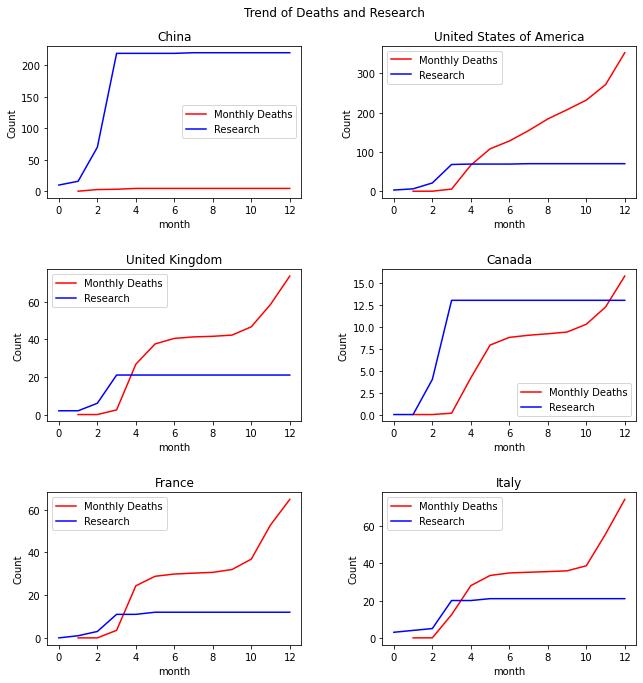

In [82]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)

plt.suptitle("Trend of Deaths and Research")

sns.lineplot(data=pvt_total_deaths2020, x='month', y="China", ax=ax[0][0],
             color="red", label="Monthly Deaths")
sns.lineplot(data=df_res, x='month', y="China", ax=ax[0][0],
             color="blue", label="Research")
ax[0][0].title.set_text('China')
ax[0][0].set_ylabel('Count')

sns.lineplot(data=pvt_total_deaths2020, x='month', y="United States",
             ax=ax[0][1], color="red", label="Monthly Deaths")
sns.lineplot(data=df_res, x='month', y="United States", color="blue",
             ax=ax[0][1], label="Research")
ax[0][1].title.set_text('United States of America')
ax[0][1].set_ylabel('Count')

sns.lineplot(data=pvt_total_deaths2020, x='month', y="United Kingdom",
             ax=ax[1][0], color="red", label="Monthly Deaths")
sns.lineplot(data=df_res, x='month', y="United Kingdom",
             ax=ax[1][0], color="blue", label="Research")
ax[1][0].title.set_text('United Kingdom')
ax[1][0].set_ylabel('Count')

sns.lineplot(data=pvt_total_deaths2020, x='month', y="Canada",
             ax=ax[1][1], color="red", label="Monthly Deaths")
sns.lineplot(data=df_res, x='month', y="Canada",
             ax=ax[1][1], color="blue", label="Research")
ax[1][1].title.set_text('Canada')
ax[1][1].set_ylabel('Count')

sns.lineplot(data=pvt_total_deaths2020, x='month', y="France",
             ax=ax[2][0], color="red", label="Monthly Deaths")
sns.lineplot(data=df_res, x='month', y="France",
             ax=ax[2][0], color="blue", label="Research")
ax[2][0].title.set_text('France')
ax[2][0].set_ylabel('Count')

sns.lineplot(data=pvt_total_deaths2020, x='month', y="Italy",
             ax=ax[2][1], color="red", label="Monthly Deaths")
sns.lineplot(data=df_res, x='month', y="Italy",
             ax=ax[2][1], color="blue", label="Research")
ax[2][1].title.set_text('Italy')
ax[2][1].set_ylabel('Count')

plt.show()

The series of plots generated from the trends of COVID death and COVID-related research per country displayed a recurring behavior in both research and death. The early months of January to late March highlighted an increase in research and low to zero research in the succeeding months. Coincidently, the deaths increased in the first quarter and minimized in the 3rd and 4th quarter and increased in the last two months. There was a similar trend between the minimization of count of both research and deaths in the middle of the year. With information gathered from research in the early months of 2020, it is more likely that preventive measures have been improved that minimized the number of deaths caused by COVID-19.

# Assessment of Results

The following are the key results from the team’s data exploration:
1. Authors like Ralph Baric (USA), Kwok-Yung Yuen (China), Shibo Jiang (China), Ziad Memish (Saudi Arabia), Christian Drosten (USA), and many others have turned out to be top authors who’ve written on topics and research on COVID-19.
2. United States, China, and United Kingdom are the countries with the greatest number of research, cited research, and researchers. 
3. Biology, Virology, Medicine, Virus, and Coronavirus are the top concept tags related to COVID-19 research and corresponding citations. 
4. It can be speculated through the plots that the research efforts made in the early months may have contributed to the decline in the death rate in succeeding months.


From this, the team surmised that the top thought leaders, institutions, and countries who led and contributed to the noble fight against this unprecedented pandemic came mostly from China, United States of America, and United Kingdom. 
However, it is imperative to note that the data that the team used might not reflect the whole picture. It is still worth noting that due to the researchers, institutions, and countries noted above, the number of deaths has slowed down, and the world is now slowly rebuilding itself.

The results presented here may be useful to future researchers and government institutions as a guide in exploring further the focus areas in the study of COVID-19 and in preparation for an instance of another pandemic hit.

# References

1. A. D. L. T. (2020). A public data lake for analysis of COVID-19 data. AWS. https://aws.amazon.com/blogs/big-data/a-public-data-lake-for-analysis-of-covid-19-data/

2. Priem, J., Piwowar, H., & Orr, R. (2022). OpenAlex: A fully-open index of scholarly works, authors, venues, institutions, and concepts. ArXiv. https://arxiv.org/abs/2205.01833

3. R. (2022). COVID-19 - World Confirmed Cases, Deaths, Testing, and Vaccinations. AWS Marketplace. https://aws.amazon.com/marketplace/pp/prodview-3b32sjummof5s#offers
